A simple online autoregressive model for time series prediction 

In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
from collections import deque
from matplotlib import pyplot as plt

# Constants

In [2]:
ar_order = 2
learning_rate = 0.05
n_samples = 5000
sigma = 0.3 # noise std

# Graph

In [3]:
# tf graph inputs
X = tf.placeholder(tf.float32, shape=[ar_order], name='history') # 1-D array
Y = tf.placeholder(tf.float32, shape=[1], name='current') # scalar

In [4]:
# tf graph variables
gamma = tf.Variable(initial_value=tf.random.truncated_normal(shape=[ar_order]), 
                    name='ar_params', dtype=tf.float32, shape=[ar_order])

In [5]:
def compute_backshift(series, ar_params, s=1):
    '''
    Compute backshift polynomial (1 - g(B)) X_t
     params:
    series: A tensor, shape (n,) - [X_t, X_{t-1}, ..., X_{t-(n-1)}]
    ar_params: A tensor, shape (p,) - [g_1, g_2, ..., g_p]
    
     returns:
    A tensor [X_t - g(B) X_t, X_{t-1} - g(B) X_{t-1}, ..., X_{t-(n-p-1)} - g(B) X_{t-(n-p-1)}], shape (n - p,)
    where
    g(B) = g_1 * B + g_2 * B^2 + ... + g_p * B^p
    '''
    n = tf.reshape(tf.shape(series), [])
    p = tf.reshape(tf.shape(ar_params), [])
    
    sliding_window = tf.map_fn(lambda i: series[i:i+p+1], tf.range(n-p), dtype=tf.float32) # shape (n-p, p+1)
    backshift_polynomial = tf.expand_dims(tf.concat([[1], -ar_params], axis=0), axis=-1) # shape (p+1, 1)
    
    result = tf.matmul(sliding_window, backshift_polynomial) # shape (n-p, 1)
    return tf.squeeze(result, axis=-1) # shape (n-p,)

In [6]:
concat = tf.concat([Y, X], axis=0) # shape (ar_order+1,)

epsilon = compute_backshift(concat, gamma)[0] # scalar value

In [7]:
prediction = -compute_backshift(tf.concat([[0], X], axis=0), gamma)

In [8]:
loss = tf.square(epsilon)

train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

In [9]:
# Initialize the variables
init = tf.global_variables_initializer()

# Train

In [10]:
series = [0] * ar_order
history = deque([0] * ar_order, maxlen=ar_order)
true_ar = np.array([0.6, -0.5])
losses = []

In [11]:
with tf.Session() as sess:
    sess.run(init)
    for i in range(n_samples-ar_order):
        x = np.dot(true_ar, np.array(history)) + np.random.normal(scale=sigma)
        l, _ = sess.run([loss, train_op], feed_dict={'history:0': np.array(history), 'current:0': np.array([x])})
        
        history.appendleft(x)
        series.append(x)
        losses.append(l)
    print(f'estimated autoregressive parameters: {sess.run(gamma)}')
    print(f'true autoregressive parameters: {true_ar}')

estimated autoregressive parameters: [ 0.5807652  -0.46065906]
true autoregressive parameters: [ 0.6 -0.5]


In [12]:
mean_losses = [np.mean(losses[:i+1]) for i in range(len(losses))]

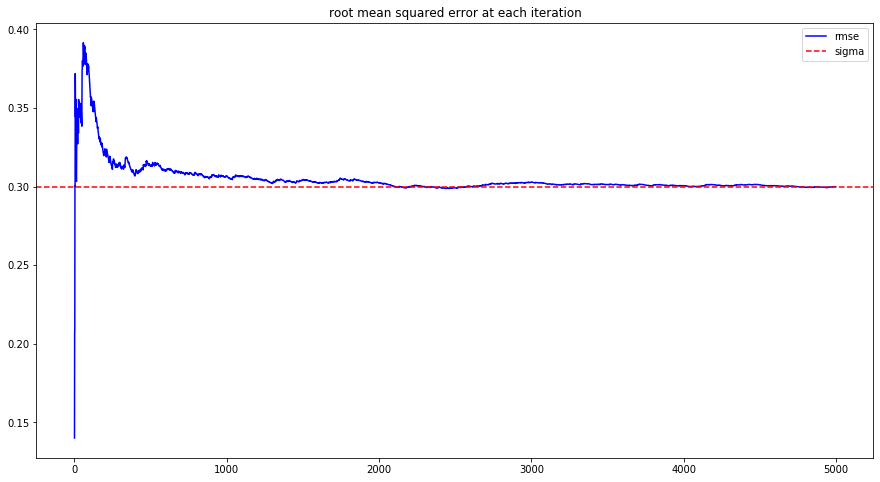

In [13]:
plt.figure(figsize=(15,8))
plt.title('root mean squared error at each iteration')
plt.plot(np.sqrt(mean_losses), color='b', label='rmse')
plt.axhline(y=sigma, color='r', linestyle='--', label='sigma')
plt.legend()
plt.show()